In [1]:
import numpy as np
import pandas as pd # we need pandas to manipulate time series
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # same as tight_layout after every plot

import pastas as ps
import os
import folium

## Temperate Climate

The Temperate Climate can be found on the Centre-East of the USA, around the states of Oklahoma, Texas and Arkansas. The Temperate climate is characterized by a mild winter and hot summers. The average winter temperatures are around 3 to 9 degrees celcius, where the summer temperatures are above 30 degrees celcius. Most of the rain falls during the spring time. 

This well is situated near Atlanta in Georgia on a height of 308.76 meters. The well is part of the Crystalline Rocks and it is classified as an unconfined aquifer. The water in the well is between 0.5 and 2.5 meters below the ground surface. The lithology of the well is unknown


The groundwater data was taken from the USGS website: https://maps.waterdata.usgs.gov/mapper/ \
The Precipitation and Temperature data was taken from the NCEI NOAA website: https://www.ncei.noaa.gov/maps/daily-summaries/ \
Using the Temperature data, the Evaporation was generated with the help of the pyet python package, using the Hargreaves formula. 

In [2]:
map = folium.Map(location=[33.70, -84.43], zoom_start=6)
folium.Marker([33.63, -84.44], popup='Weather Station').add_to(map)
folium.Marker([33.70, -84.43], popup='Well').add_to(map);

In [3]:
map

### Importing Data

#### Atlanta, Well 334207084254801
#### Groundwater series

In [5]:
height = 308.76 # meters above mean sea level

head_import = pd.read_csv('GW_Data/Atlanta_334207084254801.csv', delimiter=';', index_col=0, skiprows=0, usecols=[0, 1], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(head_import.index)
head_old = head_import.sort_index()

head = -head_old.subtract(height)  # Water level above MSL

In [6]:
head 

Date and Time
2018-01-08    306.495336
2018-01-09    306.507528
2018-01-10    306.513624
2018-01-11    306.531912
2018-05-11    307.165896
                 ...    
2024-10-27    307.156752
2024-10-28    307.141512
2024-10-29    307.135416
2024-10-30    307.129320
2024-10-31    307.135416
Name: Value, Length: 2362, dtype: float64

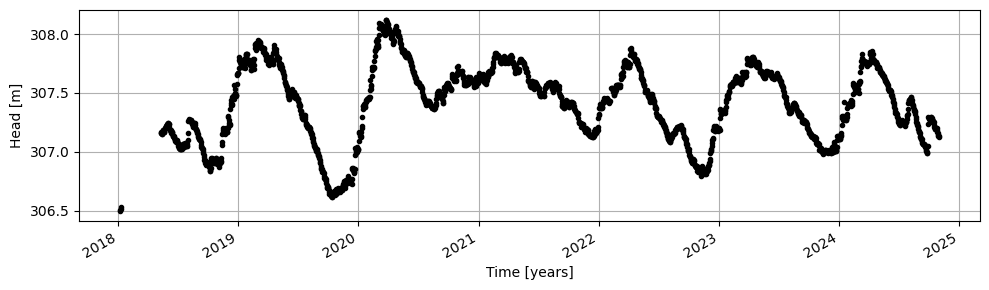

In [7]:
head.plot(linestyle="", marker=".", color="k", figsize=(10, 3))
plt.ylabel('Head [m]')
plt.xlabel('Time [years]')
plt.grid();

#### Precipitation

In [9]:
prec = pd.read_csv('Prec_temp/Atlanta_4008630.csv', delimiter=',', index_col=0, skiprows=0, usecols=[5, 10], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(prec.index)
PRCP = prec.sort_index()

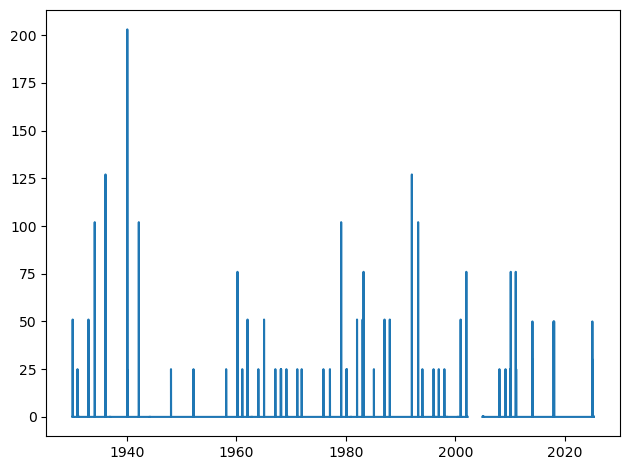

In [10]:
plt.plot(PRCP);

#### Evaporation

In [63]:
evap = pd.read_csv('Evap/Seattle.csv', delimiter=',', index_col=0, skiprows=0, usecols=[0, 1], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(evap.index)
EPOT = evap.sort_index()

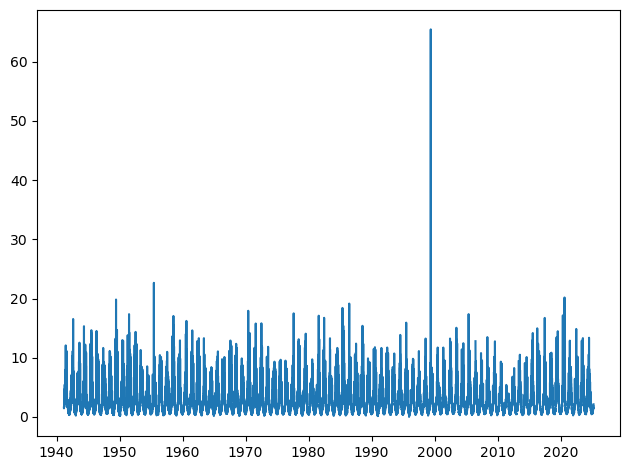

In [64]:
plt.plot(EPOT);

In [65]:
EPOT = pd.Series(np.where(EPOT > 30, np.nan, EPOT), index=EPOT.index)

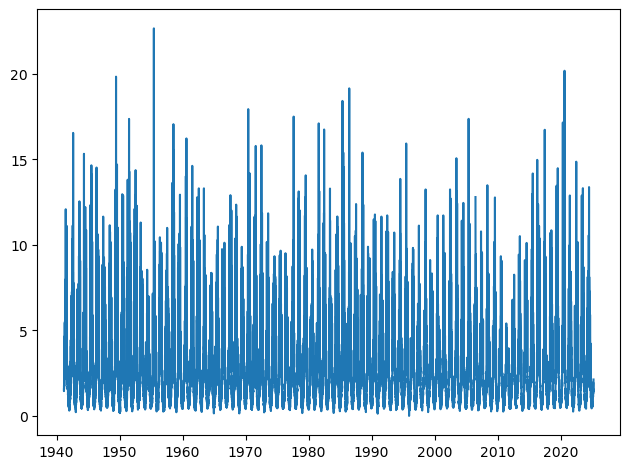

In [66]:
plt.plot(EPOT);

### Pastas Application

##### Validating the stresses

In [67]:
ps.validate_stress(EPOT)
ps.validate_stress(PRCP)

ERROR: The frequency of the index of time series None could not be inferred. Please provide a time series with a regular time step.


ValueError: The frequency of the index of time series None could not be inferred. Please provide a time series with a regular time step.

The stresses do not have a regular time step and therefore they need to be resampled with the help of Pandas

In [68]:
PRCP = PRCP.resample("24h", closed="right", label="right").mean()

In [69]:
EPOT = EPOT.resample("24h", closed="right", label="right").mean()

In [70]:
ps.validate_stress(EPOT)
ps.validate_stress(PRCP)

True

Now there are nan-values but those will be filled up with Pastas, so let's first create a basic pastas model

#### Basic Pastas Model

In [71]:
ml = ps.Model(head)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name='rch')
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                 Fit Statistics
nfev    45                     EVP        68.20
nobs    8348                   R2          0.68
noise   False                  RMSE        1.09
tmin    1987-07-16 00:00:00    AICc     1446.00
tmax    2024-06-30 00:00:00    BIC      1481.14
freq    D                      Obj      4957.45
warmup  3650 days 00:00:00     ___             
solver  LeastSquares           Interp.       No

Parameters (5 optimized)
              optimal    initial  vary
rch_A        0.370495   0.150437  True
rch_n       10.824911   1.000000  True
rch_a        7.706124  10.000000  True
rch_f       -2.000000  -1.000000  True
constant_d  60.849962  59.897331  True

Warnings! (1)
Parameter 'rch_f' on lower bound: -2.00e+00


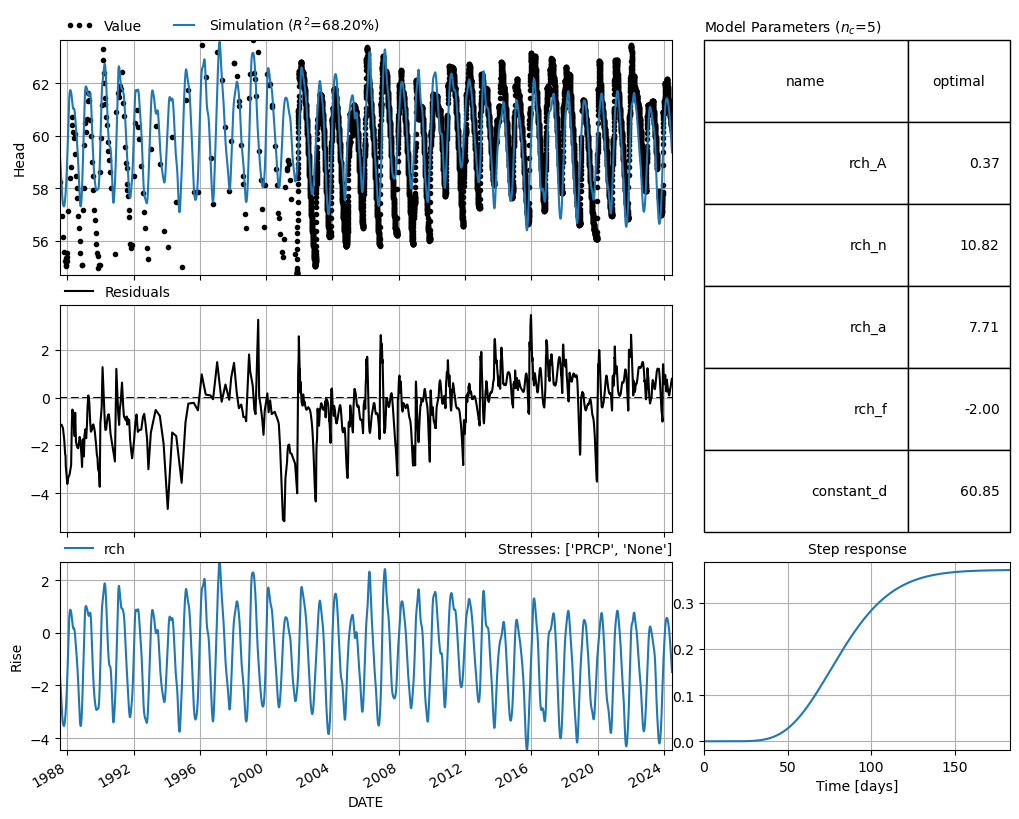

In [72]:
ml.plots.results();

#### Resample Monthly

In [73]:
head_resampled = head.resample('M').first()

In [74]:
head_resampled

Date and Time
1987-07-31    58.236000
1987-08-31    56.955840
1987-09-30    56.132880
1987-10-31    55.584240
1987-11-30    55.218480
                ...    
2024-02-29    62.006376
2024-03-31    61.829592
2024-04-30    61.637568
2024-05-31    60.982248
2024-06-30    60.625632
Freq: M, Name: Value, Length: 444, dtype: float64

In [75]:
ml = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name='rch')
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'Value': 56 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                Fit Statistics
nfev    56                     EVP       63.66
nobs    388                    R2         0.64
noise   False                  RMSE       1.29
tmin    1987-07-31 00:00:00    AICc     205.02
tmax    2024-06-30 00:00:00    BIC      224.66
freq    D                      Obj      320.56
warmup  3650 days 00:00:00     ___            
solver  LeastSquares           Interp.      No

Parameters (5 optimized)
              optimal    initial  vary
rch_A        0.401328   0.150437  True
rch_n       14.700636   1.000000  True
rch_a        7.512458  10.000000  True
rch_f       -2.000000  -1.000000  True
constant_d  60.593858  59.608637  True

Warnings! (1)
Parameter 'rch_f' on lower bound: -2.00e+00


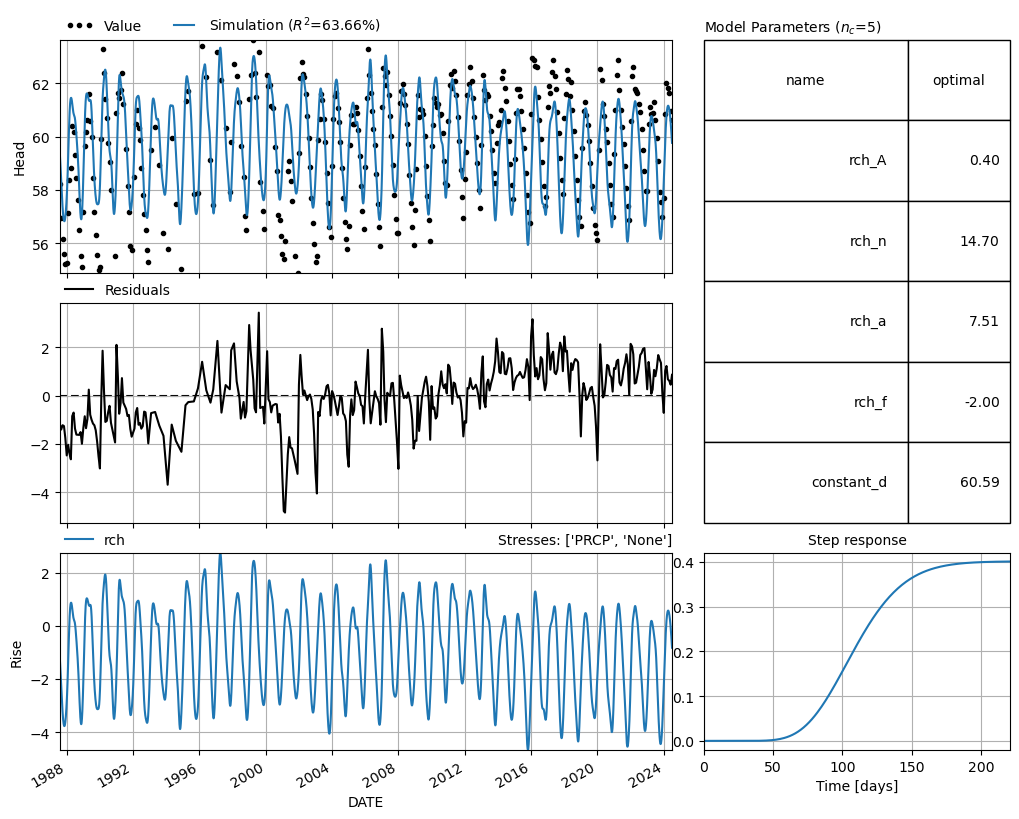

In [76]:
ml.plots.results();

### Try out different response functions and recharge models

In [77]:
ml = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Spline(), name="rch", recharge=ps.rch.Peterson())
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'Value': 56 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                Fit Statistics
nfev    41                     EVP       64.27
nobs    388                    R2         0.64
noise   False                  RMSE       1.27
tmin    1987-07-31 00:00:00    AICc     223.88
tmax    2024-06-30 00:00:00    BIC      289.56
freq    D                      Obj      315.12
warmup  3650 days 00:00:00     ___            
solver  LeastSquares           Interp.      No

Parameters (17 optimized)
              optimal    initial   vary
rch_A        9.509730   0.820459   True
rch_1        0.023381   0.090909   True
rch_2        0.094241   0.181818   True
rch_4        0.009382   0.272727   True
rch_8        0.000212   0.363636   True
rch_16       0.000119   0.454545   True
rch_32       0.000028   0.545455   True
rch_64       0.378248   0.636364   True
rch_128      0.999140   0.727273   True
rch_256      0.999758   0.818182   True
rch_512      0.476207   0.909091   True
rch_1024     1.000000   1.000000  False
rch_scap     1.833977   1.5000

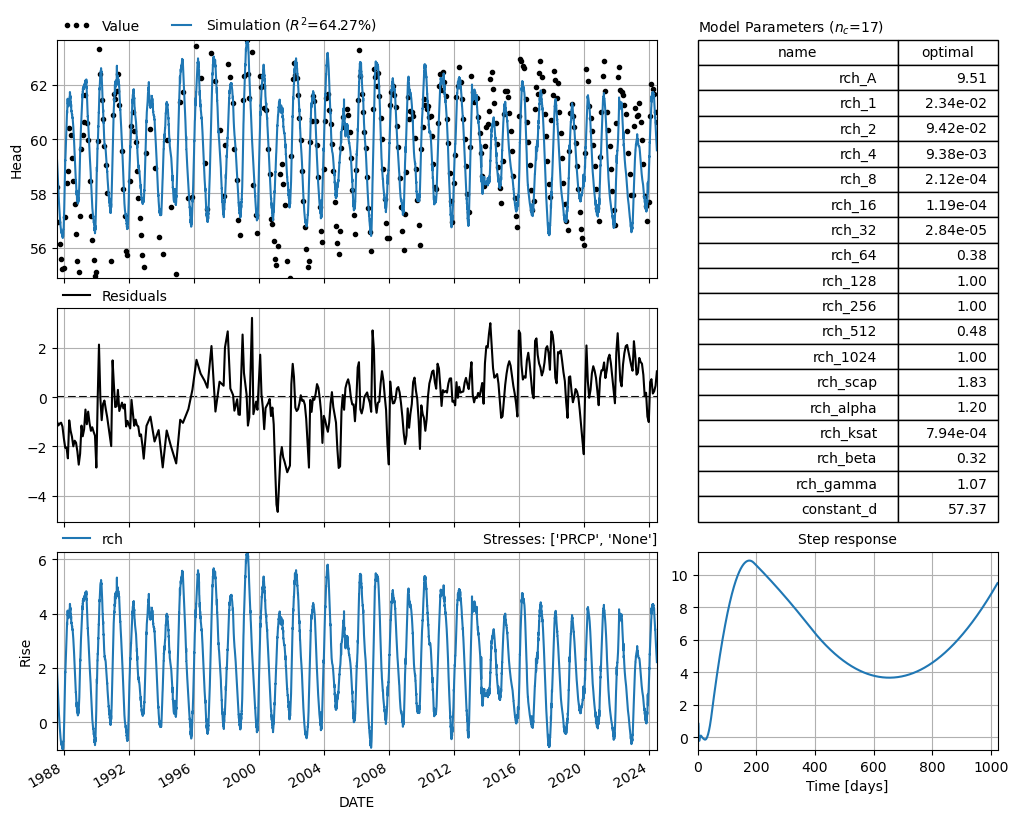

In [44]:
ml.plots.results();

In [78]:
ml = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.Peterson())
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'Value': 56 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                Fit Statistics
nfev    55                     EVP       60.50
nobs    388                    R2         0.61
noise   False                  RMSE       1.34
tmin    1987-07-31 00:00:00    AICc     245.62
tmax    2024-06-30 00:00:00    BIC      280.79
freq    D                      Obj      348.37
warmup  3650 days 00:00:00     ___            
solver  LeastSquares           Interp.      No

Parameters (9 optimized)
              optimal    initial  vary
rch_A       20.863681   0.820459  True
rch_n        4.560288   1.000000  True
rch_a       23.503829  10.000000  True
rch_scap     1.596634   1.500000  True
rch_alpha    1.499995   1.000000  True
rch_ksat     0.000203   1.000000  True
rch_beta     0.544298   0.500000  True
rch_gamma    1.447330   1.000000  True
constant_d  56.902010  59.608637  True

Warnings! (1)
Parameter 'rch_alpha' on upper bound: 1.50e+00


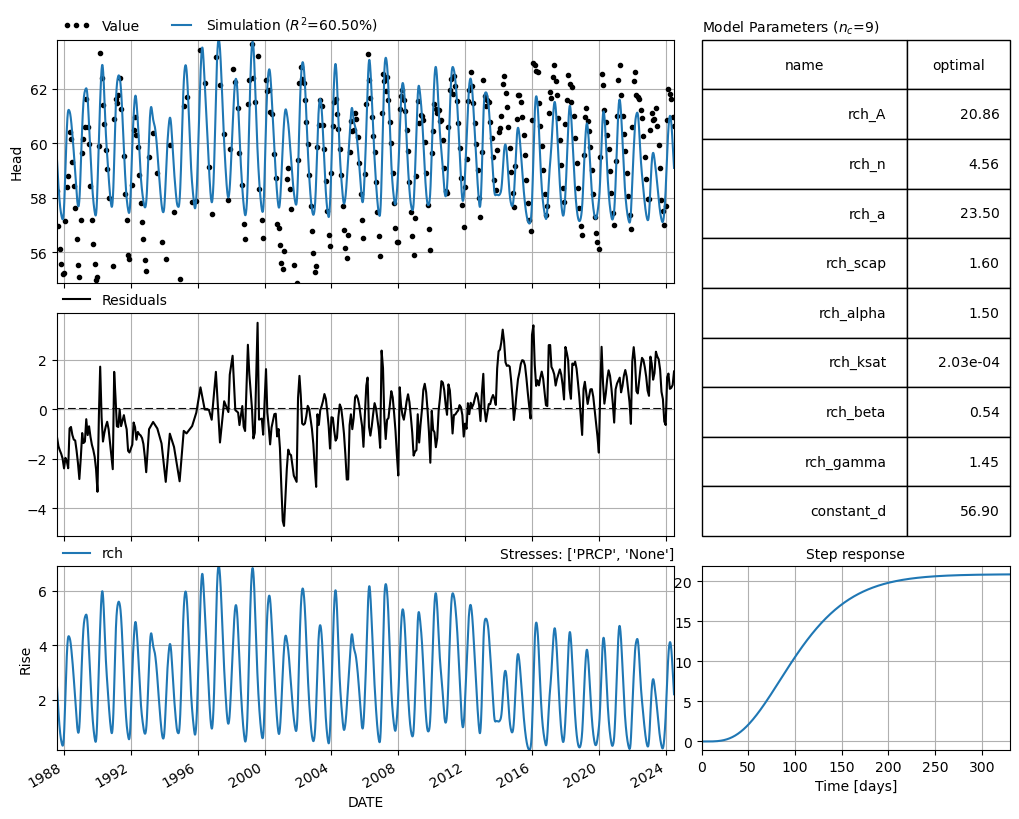

In [79]:
ml.plots.results();

### Only with daily head data (2002-2024)

In [49]:
head_daily = head.loc["2002":"2024"]

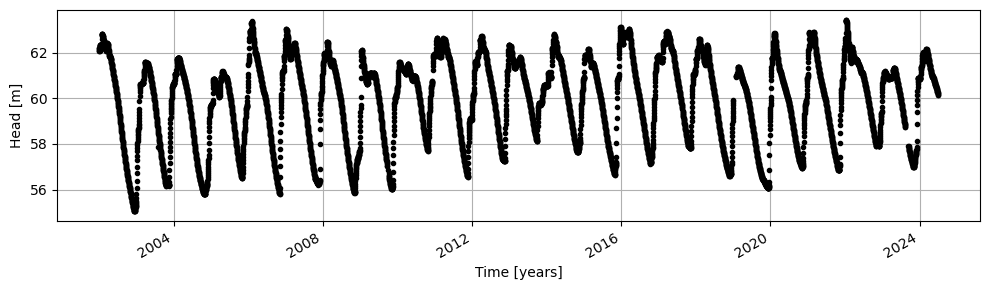

In [50]:
head_daily.plot(linestyle="", marker=".", color="k", figsize=(10, 3))
plt.ylabel('Head [m]')
plt.xlabel('Time [years]')
plt.grid();

In [51]:
ml = ps.Model(head_daily)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name='rch')
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                 Fit Statistics
nfev    37                     EVP        69.33
nobs    8125                   R2          0.69
noise   False                  RMSE        1.06
tmin    2002-01-01 00:00:00    AICc      893.24
tmax    2024-06-30 00:00:00    BIC       928.25
freq    D                      Obj      4529.01
warmup  3650 days 00:00:00     ___             
solver  LeastSquares           Interp.       No

Parameters (5 optimized)
              optimal    initial  vary
rch_A        0.366384   0.150437  True
rch_n       11.222000   1.000000  True
rch_a        7.427606  10.000000  True
rch_f       -2.000000  -1.000000  True
constant_d  60.866171  59.925287  True

Warnings! (1)
Parameter 'rch_f' on lower bound: -2.00e+00


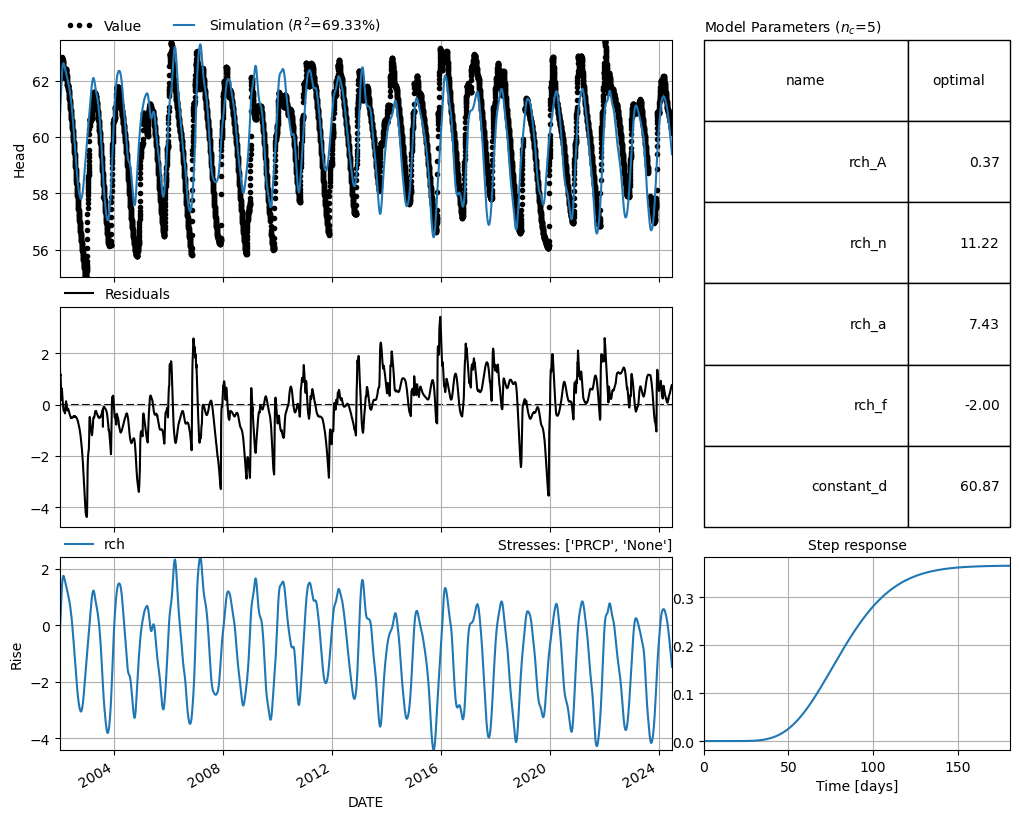

In [52]:
ml.plots.results();

#### Different Recharge and response functions

In [126]:
ml = ps.Model(head_daily)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Exponential(), name="rch", recharge=ps.rch.Linear())
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                 Fit Statistics
nfev    27                     EVP        49.37
nobs    8125                   R2          0.49
noise   False                  RMSE        1.36
tmin    2002-01-01 00:00:00    AICc     4962.38
tmax    2024-06-30 00:00:00    BIC      4990.39
freq    D                      Obj      7475.03
warmup  3650 days 00:00:00     ___             
solver  LeastSquares           Interp.       No

Parameters (4 optimized)
               optimal    initial  vary
rch_A         0.554839   0.150437  True
rch_a       108.428795  10.000000  True
rch_f        -1.999969  -1.000000  True
constant_d   61.379235  59.925287  True


In [127]:
ml1 = ps.Model(head_daily)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Exponential(), name="rch", recharge=ps.rch.Berendrecht())
ml1.add_stressmodel(sm)
ml1.solve()

INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                 Fit Statistics
nfev    600                    EVP        46.79
nobs    8125                   R2          0.47
noise   False                  RMSE        1.39
tmin    2002-01-01 00:00:00    AICc     5371.28
tmax    2024-06-30 00:00:00    BIC      5413.29
freq    D                      Obj      7856.97
warmup  3650 days 00:00:00     ___             
solver  LeastSquares           Interp.       No

Parameters (6 optimized)
                optimal     initial   vary
rch_A          1.305987    0.464650   True
rch_a         54.650952   10.000000   True
rch_fi         0.900000    0.900000  False
rch_fc         1.000000    1.000000  False
rch_sr         0.250000    0.250000  False
rch_de       924.492249  250.000000   True
rch_l         -1.098318    2.000000   True
rch_m          0.500000    0.500000  False
rch_ks      1322.119846  100.000000   True
constant_d    58.475359   59.925287   True

Warnings! (2)
Model parameters could not be estimated well.
Paramete

In [128]:
ml2 = ps.Model(head_daily)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Exponential(), name="rch", recharge=ps.rch.FlexModel())
ml2.add_stressmodel(sm)
ml2.solve()

INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                 Fit Statistics
nfev    339                    EVP        47.32
nobs    8125                   R2          0.47
noise   False                  RMSE        1.38
tmin    2002-01-01 00:00:00    AICc     5289.23
tmax    2024-06-30 00:00:00    BIC      5331.23
freq    D                      Obj      7778.02
warmup  3650 days 00:00:00     ___             
solver  LeastSquares           Interp.       No

Parameters (6 optimized)
               optimal     initial   vary
rch_A         1.137769    0.392336   True
rch_a        52.115116   10.000000   True
rch_srmax   917.488449  250.000000   True
rch_lp        0.250000    0.250000  False
rch_ks      256.509130  100.000000   True
rch_gamma     2.547981    2.000000   True
rch_kv        1.000000    1.000000  False
rch_simax     2.000000    2.000000  False
constant_d   58.352439   59.925287   True


In [129]:
ml3 = ps.Model(head_daily)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Exponential(), name="rch", recharge=ps.rch.Peterson())
ml3.add_stressmodel(sm)
ml3.solve()

INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                 Fit Statistics
nfev    58                     EVP        64.02
nobs    8125                   R2          0.64
noise   False                  RMSE        1.14
tmin    2002-01-01 00:00:00    AICc     2195.86
tmax    2024-06-30 00:00:00    BIC      2251.86
freq    D                      Obj      5312.63
warmup  3650 days 00:00:00     ___             
solver  LeastSquares           Interp.       No

Parameters (8 optimized)
                 optimal    initial  vary
rch_A       5.130582e+00   0.820459  True
rch_a       4.636077e+01  10.000000  True
rch_scap    2.275781e+00   1.500000  True
rch_alpha   1.116339e-05   1.000000  True
rch_ksat    7.189656e-14   1.000000  True
rch_beta    1.121968e-01   0.500000  True
rch_gamma   3.890128e-01   1.000000  True
constant_d  5.748354e+01  59.925287  True

Warnings! (1)
Parameter 'rch_ksat' on lower bound: 0.00e+00


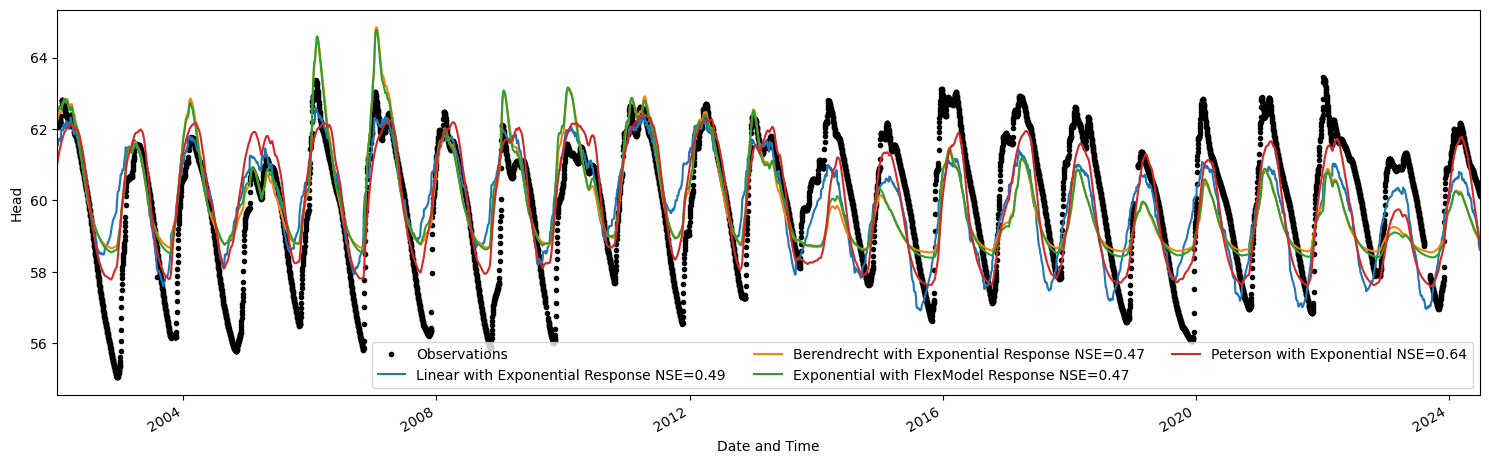

In [131]:
ax = ml.plot(figsize=(15, 5))
ml1.simulate().plot(ax=ax)
ml2.simulate().plot(ax=ax)
ml3.simulate().plot(ax=ax)
plt.legend(
    [
        "Observations",
        "Linear with Exponential Response NSE={:.2f}".format(ml.stats.nse()),
        "Berendrecht with Exponential Response NSE={:.2f}".format(ml1.stats.nse()),
        "Exponential with FlexModel Response NSE={:.2f}".format(ml2.stats.nse()),
        "Peterson with Exponential NSE={:.2f}".format(ml3.stats.nse()),
    ],
    ncol=3,
)

It appears as if the model does not reach the lower part of the observations. As the groundwater is quite close to the surface, adding the 'Groundwater uptake = True' feature, this could be resolved.

#### Groundwater uptake is true

In [31]:
ml = ps.Model(head_daily)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Spline(), name="rch", recharge=ps.rch.FlexModel(gw_uptake=True))
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                 Fit Statistics
nfev    45                     EVP        70.87
nobs    8125                   R2          0.71
noise   False                  RMSE        1.03
tmin    2002-01-01 00:00:00    AICc      494.51
tmax    2024-06-30 00:00:00    BIC       606.48
freq    D                      Obj      4300.43
warmup  3650 days 00:00:00     ___             
solver  LeastSquares           Interp.       No

Parameters (16 optimized)
                 optimal     initial   vary
rch_A       5.150158e-01    0.247616   True
rch_1       1.523917e-24    0.090909   True
rch_2       3.168755e-27    0.181818   True
rch_4       3.451988e-16    0.272727   True
rch_8       1.071483e-18    0.363636   True
rch_16      1.988963e-05    0.454545   True
rch_32      2.306231e-02    0.545455   True
rch_64      3.581829e-01    0.636364   True
rch_128     1.000000e+00    0.727273   True
rch_256     3.751178e-01    0.818182   True
rch_512     4.315677e-01    0.909091   True
rch_1024    1

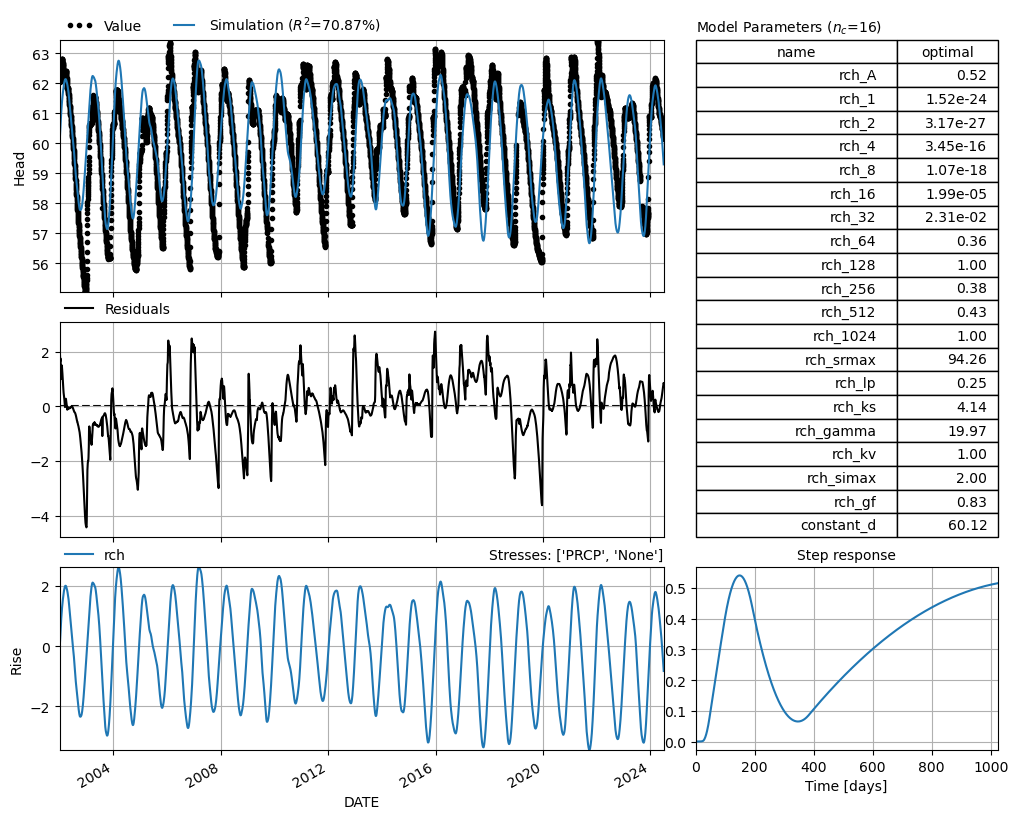

In [32]:
ml.plots.results();

In [33]:
ml1 = ps.Model(head_daily)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Spline(), name="rch", recharge=ps.rch.FlexModel())
ml1.add_stressmodel(sm)
ml1.solve()

INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 2283 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 1821 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                 Fit Statistics
nfev    67                     EVP        66.01
nobs    8125                   R2          0.66
noise   False                  RMSE        1.11
tmin    2002-01-01 00:00:00    AICc     1747.94
tmax    2024-06-30 00:00:00    BIC      1852.92
freq    D                      Obj      5019.00
warmup  3650 days 00:00:00     ___             
solver  LeastSquares           Interp.       No

Parameters (15 optimized)
                 optimal     initial   vary
rch_A       9.749776e-01    0.392336   True
rch_1       5.038267e-20    0.090909   True
rch_2       1.251055e-18    0.181818   True
rch_4       2.361899e-18    0.272727   True
rch_8       6.026087e-13    0.363636   True
rch_16      6.860696e-02    0.454545   True
rch_32      3.150481e-01    0.545455   True
rch_64      1.000000e+00    0.636364   True
rch_128     1.000000e+00    0.727273   True
rch_256     7.465988e-16    0.818182   True
rch_512     8.489706e-01    0.909091   True
rch_1024    1

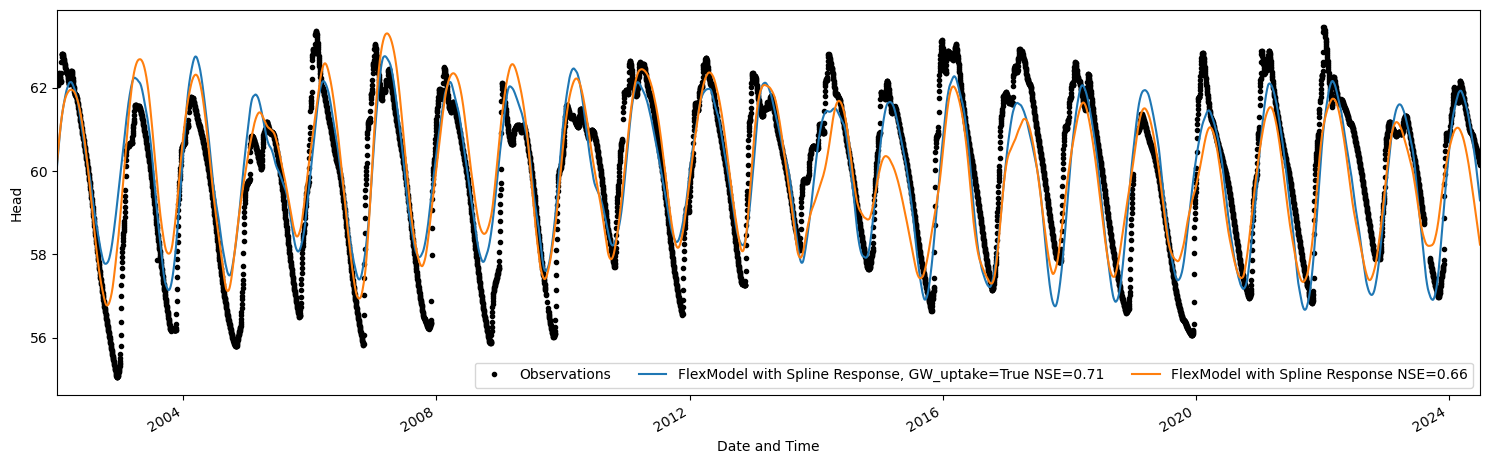

In [34]:
ax = ml.plot(figsize=(15, 5))
ml1.simulate().plot(ax=ax)
plt.legend(
    [
        "Observations",
        "FlexModel with Spline Response, GW_uptake=True NSE={:.2f}".format(ml.stats.nse()),
        "FlexModel with Spline Response NSE={:.2f}".format(ml1.stats.nse()),
    ],
    ncol=3,
)